# "Concevez une application au service de la santé publique"
_Analysis Notebook_

In [0]:
from google.colab import files, drive
drive.mount('/gdrive')
%cd /gdrive
# /gdrive/My Drive/--DATA SCIENCE/PROJET3/P3_Cleaning_functions.py

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
import os
if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET3':
    os.chdir('My Drive/--DATA SCIENCE/PROJET3')

In [0]:
# May need to reboot the environment
!pip install -r "requirements.txt"
!pip install ppscore
!pip install simplejson
!pip install mlxtend
!pip install gTTS

     |████████████████████████████████| 133kB 9.0MB/s 
     |████████████████████████████████| 6.2MB 8.7MB/s 
     |████████████████████████████████| 7.5MB 43.5MB/s 
     |████████████████████████████████| 153kB 44.9MB/s 
     |████████████████████████████████| 348kB 40.5MB/s 
     |████████████████████████████████| 20.2MB 1.3MB/s 
ERROR: Could not find a version that satisfies the requirement python-apt==1.6.5+ubuntu0.2 (from -r requirements.txt (line 271)) (from versions: 0.0.0, 0.7.8)
ERROR: No matching distribution found for python-apt==1.6.5+ubuntu0.2 (from -r requirements.txt (line 271))
  Created wheel for ppscore: filename=ppscore-0.0.2-py2.py3-none-any.whl size=9629 sha256=9622b5761a5154b1b338b3ae4ed8babd6a639e5931a4cfe2acd8df8f25990337
  Stored in directory: /root/.cache/pip/wheels/29/32/a2/82782fc09f5cd68e401ff047201d38af8965fb94984db18aa5
Successfully built ppscore
     |████████████████████████████████| 92kB 5.2MB/s 
  Created wheel for simplejson: filename=simplejson-3.17

In [0]:
import os
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import simplejson as json
import missingno as msno
import ppscore as pps

import joblib
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
# from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, train_test_split
# from sklearn import metrics
from sklearn.impute import KNNImputer
# from sklearn.dummy import DummyRegressor, DummyClassifier
# from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans

from P3_Cleaning_functions import *

plt.rcParams['figure.facecolor']='w'

# To play audio text-to-speech during execution
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

# Get list of dtype from json
f = open('d_types.json', 'r')
d_types = json.loads(f.read().replace('datetime64', 'object'))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def print_null_pct(df):
    tot_null = df.isna().sum().sum()
    print('nb of null: ', tot_null, '\npct of null: ',
        '{:.1f}'.format(tot_null*100/(df.shape[0]*df.shape[1])))

In [0]:
# Import cleaned dataset

df_init = pd.read_csv('OFF_Cleaned.csv',
                 index_col='Unnamed: 0', dtype=d_types,
                 low_memory=False, encoding ='utf-8')
df_init['created_datetime'] = pd.to_datetime(df_init['created_datetime'])

In [0]:
# Checking columns in df

for i, c in enumerate(df_init.columns):
    print('\n'+c if i % 6 == 0 else c, end=' | ')


code | code_val | categories_main | categories_tuple | url | main_category | 
quantity_unit | quantity_num | serving_quantity | quantity_type | labels_main | labels_tuple | 
pnns2 | pnns1 | creator | created_datetime | product_name | countries_main | 
brands_main | packaging_main | packaging_tuple | brands_tuple | allergens_main | allergens_tuple | 
countries_tuple | ingredients_text | additives_main | traces_main | traces_tuple | additives_tuple | 
additives_n | nutriscore | nutrigrade | nova_group | fat_100g | saturated_fat_100g | 
carbohydrates_100g | sugars_100g | fiber_100g | proteins_100g | salt_100g | sodium_100g | 
energy_from_fat_kj_100g | energy_kj_100g | ing_from_palm_oil_n | 

## 0 Preliminaries

In [0]:
print(df_init.shape)
print_null_pct(df_init)

(563352, 45)
nb of null:  4562871 
pct of null:  18.0


### 0.1 Overview of missing data

In [0]:
# Displaying number of missing values

def plot_export_missing(df, cols, n_file, title,
                        shorten_label=False, figsize=(12,8)):
    with plt.style.context('default'):
        fig, axs = plt.subplots(2,1)
        msno.matrix(df[cols] , sparkline=False,
                    fontsize=11, ax=axs[0])
        msno.bar(df[cols], ax=axs[1], fontsize=11)
        if shorten_label:
            for ax in axs:
                lab = [item.get_text() for item in ax.get_xticklabels()]
                short_lab = [s[:7]+'...'+s[-7:] if len(s)>14 else s for s in lab]
                ax.axes.set_xticklabels(short_lab)
    fig.set_size_inches(figsize)
    [ax.grid() for ax in axs.flatten()];
    [sns.despine(ax=ax, right=False, left=False,top=False, bottom=False)\
                                                       for ax in axs.flatten()];
    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout(rect=[0, 0.05, 1, 0.92])
    fig.suptitle(title, fontweight='bold', fontsize=14)
    plt.savefig('/content/' + n_file, dpi=400);
    plt.show()

We can split cleaned data in 4 categories, each of them being either quantitative (col_X_Q) or categorical (col_X_C).

NB: Among categorical data, some are lists (col_X_C_) that should be treated separately. We could for example duplicate products (1 per item of the list).

1. [cols_1]: almost totally filled (>90%), can be infered (median or more frequent)
2. [cols_2]: missing data <50%, can be infered (model)
3. [cols_3]: missing data can be infered with 0 (optional data)
4. [cols_4]: missing data, cannot be infered, but possible to drop nan and study the remainers as a subset




In [0]:
speak('overview of missing data: done')

### 0.2 Imputation

In [0]:
# Splitting columns in categories
info_cols =  ['code','code_val','url','creator','created_datetime',
              'product_name', 'ingredients_text']
cols_1_Q = ['nutriscore','fat_100g','carbohydrates_100g','proteins_100g',
            'salt_100g','saturated_fat_100g', 'sugars_100g', 'sodium_100g',
            'energy_kj_100g','energy_from_fat_kj_100g']
cols_1_C = ['nutrigrade', 'countries_main', 'categories_main']
cols_1_C_ = ['countries_tuple', 'categories_tuple']

cols_2_Q = ['fiber_100g']
cols_2_C = ['nova_group', 'pnns1', 'pnns2', 'main_category']
cols_2_C_ = []

cols_3_Q = ['ing_from_palm_oil_n','additives_n']
cols_3_C = ['additives_main','labels_main','allergens_main', 'traces_main']
cols_3_C_ = ['additives_tuple','labels_tuple','allergens_tuple', 'traces_tuple']

cols_4_Q = ['quantity_num', 'serving_quantity']
cols_4_C = ['brands_main','packaging_main', 'quantity_type','quantity_unit']
cols_4_C_ = ['brands_tuple','packaging_tuple']

In [0]:
df = df_init.copy('deep')

#### **Case 1**: almost totally filled (>90%), can be infered (median or more frequent)

In [0]:
# Case1 : imputation with most frequent or median

for c in cols_1_Q:
    df[c] = df[c].fillna(df[c].median())
for c in cols_1_C:
    df[c] = df[c].fillna(df[c].mode()[0])
for c in cols_1_C_:
    df[c] = df[c].fillna((df[c].mode()[0]))

In [0]:
speak('imputation case 1: done')

#### **Case 2**: missing data <50%, can be infered (model)

NB: We'll suppose here that data is missing at random!!!

col_2_C : ['nova_group', 'pnns1', 'pnns2', 'main_category']

In [0]:
# Data preprocessing, Knn training, then predicting all-in-one
# inferring 'main_category' (2_C) from ....+'categories_main' (1_C)

var_model = ['carbohydrates_100g','nutriscore','energy_kj_100g',
             'categories_main']
var_target = 'main_category'
ind_to_impute, y_pr_ = Knn_impute(df, var_model = var_model,
                                        var_target=var_target,
                                        enc_strat_cat='label', plot=False)
'''var_model = ['carbohydrates_100g','nutriscore','energy_kj_100g',
             'categories_main']
              model: f1=0.471, precision=0.471, recall=0.471
              TRES LONG A TOURNER
'''

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


ooooooo CLASSIFICATION METRICS oooooooo
--- model: f1=0.471, precision=0.471, recall=0.471
--- dummy class. (stratified): f1=0.00881, precision=0.00881, recall=0.00881
--- dummy class. (most_frequent): f1=0.0599, precision=0.0599, recall=0.0599
--- dummy class. (uniform): f1=0.000273, precision=0.000273, recall=0.000273


"var_model = ['carbohydrates_100g','nutriscore','energy_kj_100g',\n             'categories_main']\n              model: f1=0.468, precision=0.468, recall=0.468\n              TRES LONG A TOURNER\n"

In [0]:
# Imputing values to 'main_category
df.loc[ind_to_impute, 'main_category'] = y_pr_

In [0]:
# Data preprocessing, Knn training, then predicting all-in-one
# inferring 'pnns2' (2_C) from .... + 'main_category' (2_C)

var_model = ['carbohydrates_100g', 'fat_100g','nutriscore','energy_kj_100g',
             'proteins_100g', 'main_category']
var_target = 'pnns2'
ind_to_impute, y_pr_ = Knn_impute(df, var_model = var_model,
                                        var_target=var_target,
                                        enc_strat_cat='label', plot=False)
'''var_model = ['carbohydrates_100g', 'fat_100g','nutriscore','energy_kj_100g',
             'proteins_100g', 'main_category']
              model: f1=0.961, precision=0.961, recall=0.961
              LONG A TOURNER
'''

ooooooo CLASSIFICATION METRICS oooooooo
--- model: f1=0.961, precision=0.961, recall=0.961
--- dummy class. (stratified): f1=0.0513, precision=0.0513, recall=0.0513
--- dummy class. (most_frequent): f1=0.104, precision=0.104, recall=0.104
--- dummy class. (uniform): f1=0.0252, precision=0.0252, recall=0.0252


In [0]:
# Imputing values to 'pnns2'
df.loc[ind_to_impute, 'pnns2'] = y_pr_

In [0]:
# Data preprocessing, Knn training, then predicting all-in-one
# inferring 'pnns1' (2_C) from .... + 'pnns2' (2_C)

var_model = ['carbohydrates_100g', 'fat_100g','nutriscore','energy_kj_100g',
             'proteins_100g','main_category']
var_target = 'pnns1'
ind_to_impute, y_pr_ = Knn_impute(df, var_model = var_model,
                                        var_target=var_target,
                                        enc_strat_cat='label', plot=False)
'''var_model = ['carbohydrates_100g', 'fat_100g','nutriscore','energy_kj_100g',
             'proteins_100g', 'main_category']
              f1=0.98, precision=0.98, recall=0.98
              LONG A TOURNER
'''

ooooooo CLASSIFICATION METRICS oooooooo
--- model: f1=0.98, precision=0.98, recall=0.98
--- dummy class. (stratified): f1=0.128, precision=0.128, recall=0.128
--- dummy class. (most_frequent): f1=0.207, precision=0.207, recall=0.207
--- dummy class. (uniform): f1=0.111, precision=0.111, recall=0.111


In [0]:
# Imputing values to 'pnns1'
df.loc[ind_to_impute, 'pnns1'] = y_pr_

In [0]:
# Data preprocessing, Knn training, then predicting all-in-one
# inferring 'nova_group' (2_C) from .... + 'pnns2' (2_C)

var_model = ['carbohydrates_100g', 'fat_100g','nutriscore','energy_kj_100g',
             'proteins_100g','pnns2', 'main_category', 'categories_main']
var_target = 'nova_group'
ind_to_impute, y_pr_ = Knn_impute_bis(df, var_model = var_model,
                                        var_target=var_target,
                                        enc_strat_cat='label', plot=False)

--- model: 0.675
--- normal random distribution: -14.1
--- dummy regressor (mean): -5.72e-06
--- dummy regressor (median): -0.372


In [0]:
# Imputing values to 'nova_group'
df.loc[ind_to_impute, 'nova_group'] = y_pr_

In [0]:
speak('imputation case 2 qualitative done')

cols_2_Q : 'fiber_100g'

In [0]:
def Knn_impute_bis(df, var_model, var_target, enc_strat_cat='label',
                   clip=None, plot=True):
    if df[var_target].isna().sum()==0:
        print('ERROR: Nothing to impute (target column already filled)')
        return None, None
    else :
        if df[var_target].dtype =='object':
            # knn classifier
            skf = StratifiedKFold(n_splits=5, shuffle=True)
            gsCV = GridSearchCV(KNeighborsClassifier(),
                            {'n_neighbors': [5,7,9,11,13]},
                            cv=skf, return_train_score=True,
                            scoring='f1_weighted')
            mod = 'class'
        elif df[var_target].dtype in ['float64', 'int64']:
            # knn regressor
            kf = KFold(n_splits=5, shuffle=True)
            gsCV = GridSearchCV(KNeighborsRegressor(),
                            {'n_neighbors': [3,5,7,9,11,13]},
                            cv=kf, return_train_score=True)
            mod = 'reg'
        else:
            print("ERROR: dtype of target feature unknown")
        ## Data Preprocessing
        X, y = data_preprocessing(df.dropna(subset=var_model+[var_target]),
                                var_model=var_model, var_target=var_target,
                                enc_strat_cat=enc_strat_cat)
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
        ## Training KNN
        gsCV.fit(X_tr, y_tr)
        res = gsCV.cv_results_
        ## Predicting test set with the model and clipping
        y_pr = gsCV.predict(X_te)
        try:
            if clip: y_pr = y_pr.clip(*clip) # regressor option only
        except:
            print("ERROR: clip available for regressor option only") 
        # Comparison with naive baselines
        if mod == 'class':
            naive_model_compare_acc_f1(X_tr,y_tr,X_te,y_te,y_pr,average='micro')
        elif mod == 'reg':
            naive_model_compare_r2(X_tr,y_tr,X_te,y_te,y_pr)
        else:
            print("ERROR: check type of target feature...")
        ## Predicting using knn
        ind_to_impute = df.loc[df[var_target].isna()].index 
        X_, y_ = data_preprocessing(df.loc[ind_to_impute], var_model=var_model,
                                    var_target=var_target,
                                    enc_strat_cat=enc_strat_cat)
        # Predicting with model
        y_pr_ = gsCV.predict(X_)
        # Plotting histogram of predicted values
        short_lab = True if mod == 'class' else False
        if plot: plot_hist_pred_val(y_te, y_pr, y_pr_, short_lab=short_lab)
        # returning indexes to impute and calculated values
        return ind_to_impute, y_pr_

--- model: 0.688
--- normal random distribution: -0.504
--- dummy regressor (mean): -1.6e-05
--- dummy regressor (median): -0.0896


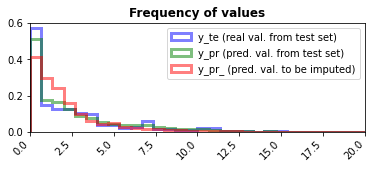

In [0]:
# Data preprocessing, Knn training, then predicting all-in-one
# inferring 'fiber_100g' (2_Q) from ...

var_model = ['carbohydrates_100g','nutriscore','energy_kj_100g','pnns1','pnns2']
var_target = 'fiber_100g'
ind_to_impute, y_pr_ = Knn_impute_bis(df, var_model=var_model,
                                      var_target=var_target,
                                      enc_strat_cat='label',
                                      clip=(0,100), plot=True) 

In [0]:
# Imputing values to 'fiber_100g'
df.loc[ind_to_impute, 'fiber_100g'] = y_pr_

In [0]:
speak('imputation case 2 quantitative: done')

#### Case 3: missing data can be infered with 0 (optional data)

In [0]:
# Case 3 : imputation with 0
for c in cols_3_Q:
    df[c] = df[c].fillna(0)
for c in cols_3_C:
    df[c] = df[c].fillna('None')
for c in cols_3_C_:
    df[c] = df[c].fillna(('None'))

In [0]:
speak('imputation case 3 qualitative done')

In [0]:
print(df.shape)
print_null_pct(df)

(563352, 45)
nb of null:  2126186 
pct of null:  8.4


In [0]:
# # Exporting the dataframe as CSV for further treatment

df.to_csv('OFF_Cleaned.csv')

## 1 Univariate analysis

### 1.1 Quantitative data

#### Histograms

In [0]:
# Plotting histograms of the main quantitative continuous columns
quant_cols = cols_1_Q + cols_2_Q + cols_3_Q + cols_4_Q
# fig = plt.figure(figsize=(14,10))
fig = df[quant_cols].hist(figsize=(18,6), bins=50, color='b',
                        xlabelsize=10, ylabelsize=10);
[x.title.set_fontweight('bold') for x in fig.ravel()];
plt.tight_layout(w_pad=1, h_pad=-0.8)
plt.gcf().set_size_inches(14,10)
#plt.savefig('histo_quant.png', dpi=400)
plt.show()

#### Normality test

Let's test normality of the distribution of our quantitative data

In [0]:
quant_cols = cols_1_Q + cols_2_Q + cols_3_Q + cols_4_Q

In [0]:
# Normality Tests
from scipy.stats import shapiro, normaltest, anderson

def normality_tests(data, print_opt=False):
    df_res = pd.DataFrame([])
    data_notna = data[data.notna()]
    # Shapiro-Wilk - D'Agostino's K^2
    for f_name, func in zip(['Shapiro-Wilk', "D'Agostino K^2"],[shapiro, normaltest]):
        stat, p = func(data_notna)
        df_res.loc[f_name,'stat'] = stat
        df_res.loc[f_name,'p_value'] = p
        if print_opt: print('---'+f_name) 
        if print_opt: print('stat=%.3f, p=%.3f' % (stat, p))
        df_res.loc[f_name,'res'] = [p > 0.05]
        if p > 0.05:
            if print_opt: print('Probably Gaussian')
        else:
            if print_opt: print('Probably not Gaussian')
    # Anderson-Darling
    result = anderson(data_notna)
    if print_opt: print('---'+'Anderson-Darling')
    df_res.loc['Anderson-Darling','stat'] = result.statistic
    if print_opt: print('stat=%.3f' % (result.statistic))
    res_and = [(int(result.significance_level[i]),result.statistic < res)\
                   for i,res in enumerate(result.critical_values)]
    df_res.loc['Anderson-Darling','res'] = str(res_and)
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < cv:
            if print_opt: print('Probably Gaussian at the %.1f%% level' % (sl))
        else:
            if print_opt: print('Probably not Gaussian at the %.1f%% level' % (sl))
    return df_res

In [0]:
# Plotting histograms and qqplots of the main quantitative continuous columns
from statsmodels.graphics.gofplots import qqplot

def plot_hist_qqplot(data, name):
    fig, axs = plt.subplots(1,2)
    # histogram
    axs[0].hist(data, color='b', bins =25);
    # with statsmodels qqplot's module
    qqplot(data, line='r', ax=axs[1])
    plt.gcf().set_size_inches(10,2.5)
    fig.suptitle(name, fontweight='bold', size=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plotting QQplots and normality tests stats
for i, c in enumerate(quant_cols,1):
    plot_hist_qqplot(df[c].values, c)
    print(c)
    display(normality_tests(df[c], print_opt=False))
    ax.set_title(c, fontweight='bold')
#plt.savefig('qqplots.png', dpi=400)

### 1.2 Qualitative data

In [0]:
qual_cols = cols_1_C + cols_2_C + cols_3_C + cols_4_C

#### Bar plots

In [0]:
# Plotting bar plots of the main categorical columns
fig = plt.figure(figsize=(14,10))
for i, c in enumerate(qual_cols,1):
    ax = fig.add_subplot(4,4,i)
    ser = df[c].value_counts()
    if ser.shape[0]>15:
        ser[0:15].plot.bar(color='b',ax=ax)
    else:
        ser.plot.bar(color='b',ax=ax)
    ax.set_title(c, fontweight='bold')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    short_labels = [s[0:7]+'.' if len(s)>7 else s for s in labels]
    ax.axes.set_xticklabels(short_labels)
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.savefig('histo_cat.png', dpi=400)
plt.show()

#### Distribution depending on categorical data

In [0]:
boxplot_cols = quant_cols

for nutrigrades subsets

In [0]:
# nutriscore

nutri_pal = ['#008000', '#78D222', '#FFD700', '#FF8D00' , '#F23824']

fig = plt.figure(figsize=(12,7))
with sns.color_palette(nutri_pal):
    for i, c in enumerate(boxplot_cols,1):
        ax = fig.add_subplot(3,4,i)
        sns.boxplot(data=df, x='nutrigrade', y=c, order=list('abcde'), ax=ax)
        min = df[c].mean()-3*df[c].std()
        max = df[c].mean()+3*df[c].std()
        plt.ylim(min,max)
plt.tight_layout()

for categories subsets

In [0]:
# pnns1

pnns1_pal = sns.color_palette(palette='bright')

fig = plt.figure(figsize=(15,10))
with sns.color_palette(pnns1_pal):
    for i, c in enumerate(boxplot_cols,1):
        ax = fig.add_subplot(3,4,i)
        sns.boxplot(data=df, x='pnns1', y=c, ax=ax)# order=list('abcde')
        min = df[c].mean()-3*df[c].std()
        max = df[c].mean()+3*df[c].std()
        plt.ylim(min,max)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        short_labels = [s[0:10]+'.' if len(s)>10 else s for s in labels]
        ax.axes.set_xticklabels(short_labels)
        plt.xticks(rotation=45, ha='right')
plt.tight_layout()

## 2 Bivariate analysis

### 2.0 Time analysis

In [0]:
# Plotting number of new items through time
fig = plt.figure(figsize=(10,5))
for i,per in enumerate(['D', 'W', 'M', 'Y'],1):
    ax = fig.add_subplot(2,2,i)
    t_ser = df.groupby(pd.Grouper(key='created_datetime', freq=per)).size()
    t_ser.plot(ax=ax, ms=5, marker='o', mfc='k', color='b', ls='-')
    ax.set(ylim=(0,np.mean(t_ser)+2*np.std(t_ser)))
    ax.set_title("nb of new items each "+per)
fig.tight_layout()

### 2.1 Linear correlation

In [0]:
def plot_heatmap(corr, title, figsize=(8,4), vmin=-1, vmax=1, center=0,
                 palette = sns.color_palette("coolwarm", 20), rect=False):
    fig, ax = plt.subplots(figsize=figsize)
    if rect==True:
        mask=None
    else:
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    palette = palette
    ax = sns.heatmap(corr, mask=mask, cmap=palette, vmin=vmin, vmax=vmax,
                     center=center, annot=True, annot_kws={"size": 10},fmt='.2f',
                     square=False, linewidths=.5, linecolor = 'white',
                     cbar_kws={"shrink": .9, 'label': None},
                     xticklabels= corr.index, yticklabels = corr.columns)
    ax.tick_params(labelsize=10,top=False, bottom=True,
                labeltop=False, labelbottom=True)
    ax.collections[0].colorbar.ax.tick_params(labelsize=10)
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right",rotation_mode="anchor")
    ax.set_title(title, fontweight='bold', fontsize=12)
    plt.show()

In [0]:
# Linear correlation (Pearson)
# cols = cols_1_Q+['fiber_100g']
cols = quant_cols
pears_corr = df[cols].corr()
plot_heatmap(pears_corr, rect=False, title="Pearson correlation", figsize=(12,5))

Some of the correlations are quite obvious, as for example:
- fat -> energy
- sugars -> carbohydrates
- fat, saturated, fat, sugars, energy -> nutriscore
- nutriscore -> nutrigrade
More suprisingly :
- more fibers can be found in high energy products

As we know from its formula, nutriscore:
- increases with energy, saturated fat, sugar and salt
- decreases with fibers, proteins and fruits and vegetable content

However, which is more interesting is that the value of correlation coefficient indicates that in the case of most of the actual products, the main factors that are correlated with nutriscore are (decreasing order):
- fat, energy, saturated fat, carbohydrates, sugar
- whereas sodium is very weakly correlated to a high nutriscore.

__=> Food industry should focus primarily on decreasing fat to lower the nutriscore of their products__.


### 2.2 Correlation tests

In [0]:
from scipy.stats import pearsonr, spearmanr, kendalltau

def correlation_tests(data1, data2, print_opt=False):
    df_res = pd.DataFrame([])
    # data1_notna = data1[data1.notna()]
    # Pearson, Spearman, Kendall
    for f_name, func in zip(['Pearson', 'Spearman', 'Kendall'],[pearsonr, spearmanr, kendalltau]):
        stat, p = func(data1, data2)
        df_res.loc[f_name,'stat'] = stat
        df_res.loc[f_name,'p_value'] = p
        if print_opt: print('---'+f_name)
        if print_opt: print('stat=%.3f, p=%.3f' % (stat, p))
        if print_opt:print('Probably independent') if p > 0.05 else print('Probably dependent')
    return df_res

In [0]:
# Correlation test
display(correlation_tests(df['fat_100g'], df['nutriscore'], print_opt=True))
display(correlation_tests(df['carbohydrates_100g'], df['nutriscore'], print_opt=False))
display(correlation_tests(df['energy_kj_100g'], df['nutriscore'], print_opt=False))
display(correlation_tests(df['fat_100g'], df['energy_kj_100g'], print_opt=False))

# for i, c in enumerate(quant_cols,1):
#     print(c)
#     display(correlation_tests(data1, data2, print_opt=False))
#     ax.set_title(c, fontweight='bold')
#plt.savefig('qqplots.png', dpi=400)

### 2.3 Correlation with Predictive Power Score (decision tree based)

In [0]:
# Predictive Power Score (ppscore)
# pps_corr = pps.matrix(df[cols_1_Q+cols_1_C+cols_2_C+cols_2_Q])
cols = quant_cols + qual_cols
pps_corr = pps.matrix(df[cols])
plot_heatmap(pps_corr, title="Predictive Score", 
             vmin=0, center=0.5, figsize=(15,8), rect=True,
             palette=sns.color_palette("inferno", 20))

It seems that categories have a strong relation to most of the nutritional values.

countries as well seem to have a strong relationship to nutritional values. 

### 2.4 Contingency table and Chi-squared

In [0]:
# ## Creating table of contingency
# data = pd.read_csv("loan_status.csv") 
# # by hand
# display(data.pivot_table(index = 'grade',
#                          columns = 'loan_status',
#                          values='purpose',
#                          aggfunc='count').fillna(0))
# # with pandas
# data_crosstab = pd.crosstab(data['grade'], 
#                             data['loan_status'],  
#                                margins = True)
# display(data_crosstab)

In [0]:
# # Chi-Squared Test
# from scipy.stats import chi2_contingency
# stat, p, dof, expected = chi2_contingency(data_crosstab)
# print('---'+"Chi-squared")
# print('stat=%.3f, p=%.3f' % (stat, p))
# print('Probably independent') if p > 0.05 else print('Probably dependent')

### 2.5 ANOVA

In [0]:
## Test de normalité à faire dans les sous-groupes

In [0]:
# Analysis of Variance Test (ANOVA)
from scipy.stats import f_oneway
stat, p = f_oneway(data1, data2)
print('---'+" ANOVA")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably same distribution\n') if p > 0.05 else print('Probably not the same distribution\n')

### 2.6 Non-parametric statistical hypothesis tests

In [0]:
# Example of the Mann-Whitney U Test
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(data1, data2)
print('---'+" U-test (Mann-Whitney)")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably same distribution\n') if p > 0.05 else print('Probably not the same distribution\n')

# Example of the Wilcoxon Signed-Rank Test
from scipy.stats import wilcoxon
stat, p = wilcoxon(data1, data2)
print('---'+" Signed-rank (Wilcoxon)")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably same distribution\n') if p > 0.05 else print('Probably not the same distribution\n')

# Example of the Kruskal-Wallis H Test
from scipy.stats import kruskal
stat, p = kruskal(data1, data2)
print('---'+" H-test (Kruskal-Wallis)")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably same distribution\n') if p > 0.05 else print('Probably not the same distribution\n')
    
# Example of the Friedman Test
from scipy.stats import friedmanchisquare
stat, p = friedmanchisquare(data1, data2, data3)
print('---'+" ANOVA")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably same distribution\n') if p > 0.05 else print('Probably not the same distribution\n')

### 2.7 Pair plots

In [0]:
# Scatterplot matrix (too much data -> on a sample)
cols = ['fat_100g', 'nutriscore','proteins_100g','carbohydrates_100g']
df_sample = df.sample(1000)

grid = sns.PairGrid(data=df_sample,
                    vars=cols, height=2.5)
grid = grid.map_upper(plt.scatter, marker='o', edgecolors='darkred',
                      alpha=0.5, color='red', s=20)
# grid = grid.map_upper(testcorr)
grid = grid.map_diag(plt.hist, bins = 20, color = 'darkred', edgecolor = 'k')
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')

#cols = ['fat_100g', 'nutriscore','proteins_100g','carbohydrates_100g']
# 1000 => CPU times: user 9.03 s, sys: 292 ms, total: 9.32 s Wall time: 9 s
# 10000 => CPU times: user 42.9 s, sys: 318 ms, total: 43.2 s Wall time: 42.9 s
# 100000 => CPU times: user 6min 40s, sys: 3.93 s, total: 6min 44s Wall time: 6min 44s

## 3 Multivariable analysis

### 3.1 PCA (Principal Component Analysis)

In [0]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, width=16,
                    label_rotation=0, lims=None, n_cols=3):
    n_rows = (n_comp+1)//n_cols
    fig = plt.figure(figsize=(width,n_rows*width/n_cols))
    # boucle sur les plans factoriels (3 premiers plans -> 6 composantes)
    for i, (d1, d2) in enumerate(axis_ranks): 
        if d2 < n_comp:
            ax = fig.add_subplot(n_rows, n_cols, i+1)
            # limites
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])
            # flèches, si plus de 30, pas de pointes
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, alpha=.1, color='black'))
            # noms de variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        ax.text(x, y, labels[i], fontsize='14', ha='center', va='center',
                                rotation=label_rotation, color="blue", alpha=0.5)
            # cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            ax.add_artist(circle)
            # définition des limites du graphique
            ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
            # affichage des lignes horizontales et verticales
            ax.plot([-1, 1], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [-1, 1], color='grey', ls='--')
            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            ax.set_title("PCA correlation circle (PC{} and PC{})".format(d1+1, d2+1))
    plt.tight_layout()
    plt.show()

In [0]:
def display_factorial_planes(X_proj, n_comp, pca, axis_ranks, labels=None,
                             width=16, alpha=1, n_cols=3, illus_var=None,
                             lab_on=True, size=10):
    n_rows = (n_comp+1)//n_cols
    fig = plt.figure(figsize=(width,n_rows*width/n_cols))
    # boucle sur chaque plan factoriel
    for i, (d1,d2) in (enumerate(axis_ranks)):
        if d2 < n_comp:
            ax = fig.add_subplot(n_rows, n_cols, i+1)
            # points
            if illus_var is None:
                ax.scatter(X_proj[:, d1], X_proj[:, d2], alpha=alpha, s=size)
            else:
                illus_var = np.array(illus_var)
                for value in np.unique(illus_var):
                    sel = np.where(illus_var == value)
                    ax.scatter(X_proj[sel, d1], X_proj[sel, d2], 
                                alpha=alpha, label=value)
                ax.legend()
            # labels points
            if labels is not None and lab_on:
                for i,(x,y) in enumerate(X_proj[:,[d1,d2]]):
                    ax.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center')   
            # limites
            bound = np.max(np.abs(X_proj[:, [d1,d2]])) * 1.1
            ax.set(xlim=(-bound,bound), ylim=(-bound,bound))
            # lignes horizontales et verticales
            ax.plot([-100, 100], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [-100, 100], color='grey', ls='--')
            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            ax.set_title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
    plt.tight_layout()

In [0]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rank")
    plt.ylabel("explained variance ratio")
    plt.title("Scree plot")
    plt.show()

In [0]:
np.set_printoptions(formatter={'float': '{: 6.3f}'.format})

df_sample = df.sample(5000)

# Feature selection for PCA
id_code = df_sample.index
# pca_cols = ['fat_100g','energy_kj_100g', 
#             'sugars_100g','sodium_100g', 'ing_from_palm_oil_n', 'nutriscore']
pca_cols = ['fat_100g', 'carbohydrates_100g', 'proteins_100g',
            'saturated_fat_100g','energy_kj_100g', 'fiber_100g',
            'sugars_100g','sodium_100g', 'ing_from_palm_oil_n', 'nutriscore']

# Imputation of missing values
print('-----missing values imputation-----')
# faire une imputation par catégorie ?
display(df_sample[pca_cols].isna().sum())
X = df_sample[pca_cols].fillna(df_sample.mean()).values

# Data standardisation
print('-----standardisation-----')
X_sc = StandardScaler().fit_transform(X)
print(X_sc)

# Principal components calculation
n = 10
pca = PCA(n_components=n).fit(X_sc)
print("\n-----explained variance ratio-----")
print(pca.explained_variance_ratio_)
print('\n-----coefficients of principal components (original features)-----')
print(pca.components_)
print('\n-----data projected in new space-----')
print(pca.transform(X_sc))

In [0]:
# Displaying scree plot
display_scree_plot(pca)

In [0]:
# Cercle des corrélations
display_circles(pca.components_, n, pca, [(0,1),(2,3),(4,5)],
                labels = np.array(pca_cols), width=15,  n_cols=3)

In [0]:
# # Plotting values on original axes
# fig = plt.figure(figsize=(16,6))
# for i, (d1,d2) in (enumerate([(0,1),(2,3),(4,5),(6,7),(8,9)])):
#     ax = fig.add_subplot (1, 5, i+1)
#     ax.scatter(X_sc[:, d1], X_sc[:, d2], alpha=0.5, s=10)

In [0]:
# Plotting values projected on first factorial planes
display_factorial_planes(pca.transform(X_sc), n, pca, [(0,1),(2,3),(4,5)],
                         n_cols=3, labels=np.array(id_code), lab_on=True)

Using mlxtend

In [0]:
# import mlxtend
from mlxtend import plotting

In [0]:
from mlxtend.data import iris_data
import mlxtend as ml
ml.data.
# figure, correlation_matrix = plotting.plot_pca_correlation_graph(X_sc, cols,
#                                                         dimensions=(1, 2),
#                                                         figure_axis_size=10)#, X_pca, explained_variance)

### 3.2 Clustering

KMeans 

In [0]:
# df = pd.read_csv('./Dataset 1/my_courses.csv', index_col=0)
# print(df.shape[0])
# X = df.fillna(df.mean()).values
# X_sc = StandardScaler().fit_transform(X)

In [0]:
# n_clust = 6
# km = KMeans(n_clusters=n_clust).fit(X_sc)

In [0]:
# # Récupération des clusters attribués à chaque individu
# clustK = km.labels_
# df['cluster_Kmeans'] = clustK
# clustK

In [0]:
# # Projection des individus sur le plan factoriel
# pca = PCA(n_components=4).fit(X_sc)
# X_proj = pca.transform(X_sc)
# display_factorial_planes(X_proj, 4, pca,
#                          [(0,1),(2,3),(4,5)], labels=np.array(df.index),
#                          illus_var = clust.astype(np.float), alpha=0.3, n_cols=3, lab_on=False, size=10)

In [0]:
# # Affichage des clusters
# for n, s_df in df.groupby('cluster_Kmeans'):
#     display(s_df)

Hierarchical clustering

In [0]:
# # Clustering hiérarchique
# Z = linkage(X_sc, 'ward')
# Z[0:15]

In [0]:
# plt.figure(figsize=(16,10))
# dendrogram(Z, labels = df.index, orientation = "right", count_sort='descending')
# plt.show()

In [0]:
# # Coupage du dendrogramme
# n_clust = 6
# clustH = fcluster(Z, n_clust, criterion='maxclust')
# df['cluster_HierClust'] = clustH
# clustH

In [0]:
# # Affichage des clusters
# for n, s_df in df.groupby('cluster_HierClust'):
#     display(s_df)